# TwitterTracker
Monitor Twitter for mentions of given search terms

In [1]:
import tweepy

### Authentication

In [2]:
credentials = {}
with open('./secrets.txt', 'r') as infile:
    for line in infile.readlines():
        if ":" in line:
            key_val = line.split(': ',1)
            credentials[key_val[0]] = key_val[1].strip()

In [3]:
auth = tweepy.OAuthHandler(credentials['consumer_key'], credentials['consumer_secret'])
auth.set_access_token(credentials['access_token'], credentials['access_token_secret'])
api = tweepy.API(auth)

### Start streaming Tweets

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    def on_status(self, status):
        print(status.text)

In [37]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener)

In [81]:
myStream.disconnect()

In [82]:
# myStream.filter(track=['NIKEiD', 'nikeid', 'NikeID'], async=False)
myStream.filter(track=['nike'], async=False)

I just entered to win an #OffWhitePresto by subscribing to @RealSethFowler on YouTube! https://t.co/68NsOOQ91T
RT @inoesasi: Buenas noches mis influencers, ¿ya son embajadores de Adidas o de Nike?
RT @hectordeandam: Buenos días influencers, ya son embajadores y socios de nike o todavía no?
RT @MayCabral4: q cosita lindas los conjuntos adidas y nike, aaaaa mil me compraría 😍❤😍❤😍❤😍❤😍❤
RT @HotNewHipHop: John Elliott x @Nike LeBron Icon slated to release again on 9/1

https://t.co/wrSVGQEhR8
RT @sneaker_wars: 【海外9月8日発売予定】 アクロニウム × ナイキ エアプレスト ミッド 全3色
⇒https://t.co/XxpgAyyFhr
新たなカラーリングがスタンバイ中！
#sneakerwars #スニーカー #NIKE https://t.c…
RT @hectordeandam: Buenos días influencers, ya son embajadores y socios de nike o todavía no?
RT @iiloveroupas: A Nike não brincar em serviço 😍 https://t.co/j9e5sUmBPP
vou lançar um corta vento da Nike rosa, pesadão
I just entered to win an #OffWhitePresto by subscribing to @RealSethFowler on YouTube! https://t.co/PzqdFgHTio
I just entered to win an #OffWhitePrest

KeyboardInterrupt: 

# Analyze the downloaded Tweets

In [1]:
import json
import numpy as np
import pandas as pd

In [2]:
# Load the Tweets
with open('./nike_tweets.json', 'r') as infile:
    raw = infile.readlines()
data = [json.loads(line) for line in raw if line != '\n']
del(data[219]) # Kludge for bad data

# Resave the Tweets in proper JSON format
with open('./nike_tweets_json.json', 'w') as outfile:
    json.dump(data, outfile)
    
# Reload the Tweets as a Pandas dataframe
tweets = pd.read_json('./nike_tweets_json.json')

# Add direct Tweet link to DF
def getTweetUrl(tweet):
    """Returns the URL to a Tweet"""
    root = 'https://twitter.com/{name}/status/{id_}'
    return root.format(name=tweet['user']['screen_name'], id_=tweet['id'])
urls = []
for i in range(len(tweets)):
    urls.append(getTweetUrl(tweets.loc[i])) # Probably not the best way
tweets['url'] = urls

tweets.head(2)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,url
0,NaN,None,2018-08-23 05:07:21,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,0,0,False,{'created_at': 'Thu Aug 16 11:45:41 +0000 2018...,"<a href=""http://twitter.com/download/android"" ...","RT @RING_KNOWS_RING: ブログ更新しました！\n\n"" NIKE KOBE...",2018-08-23 05:07:21.504,False,"{'id': 4505070073, 'id_str': '4505070073', 'na...",https://twitter.com/RING_KNOWS_RING/status/103...
1,NaN,None,2018-08-23 05:54:42,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...","{'media': [{'id': 1032223230294032385, 'id_str...",NaN,0,False,low,...,0,0,False,{'created_at': 'Wed Aug 22 11:14:04 +0000 2018...,"<a href=""http://twitter.com/download/android"" ...",RT @koheisblog: 柏レイソル\nFW クリスティアーノ 選手\n『NIKEiD...,2018-08-23 05:54:42.390,False,"{'id': 958656259237949440, 'id_str': '95865625...",https://twitter.com/q3o9IaPXU6vhRQU/status/103...


## Sentiment analysis

In [4]:
import re
from textblob import TextBlob

In [5]:
# https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet_text):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet_text))
    score = analysis.sentiment.polarity

    # Return sentiment score and category
    if score > 0:
        return score, 'positive'
    elif score == 0:
        return score, 'neutral'
    else:
        return score, 'negative'

### Add sentiment scores to the Data Frame

In [6]:
scores = np.zeros(len(tweets))
sentiments = []
for i in range(len(tweets)):
    score, sentiment = get_tweet_sentiment(tweets.loc[i]['text'])
    scores[i] = score
    sentiments.append(sentiment)
    
tweets['sentiment_score'] = scores
tweets['sentiment'] = sentiments

In [7]:
for n in range(len(tweets)):
    tweet = tweets.loc[n]
    
    if tweet['sentiment'] == 'negative':
        print('-'*60)
        print(tweet['text'])
        print(n)
        print(tweet['url'])        

------------------------------------------------------------
Nike ID Kobe Bryant XI 11 BLACK GOLD FTB 10.5 asg multicolor nikeid https://t.co/hvtMOTv2K8
56
https://twitter.com/BlogForTheCause/status/1032806248767528960
------------------------------------------------------------
NikeID is a scam, they have the worst colors to choose from. 😩
74
https://twitter.com/mduzzzy/status/1032844079581806592
------------------------------------------------------------
My 1st NIKEiD fail. My ugly babies..
@Nike https://t.co/7OsxheKkAQ
90
https://twitter.com/MoonPi_/status/1032964235276550145
------------------------------------------------------------
I AM OBSESSED 😍😍 #nikeid @Nike https://t.co/NqvuYwrHS2
122
https://twitter.com/windmi11s/status/1033055189102735362
------------------------------------------------------------
NIKEiD AIR MAX 'KISS MY AIRS' NEW BLACK/MULTICOLOR [ 940379-991 ] US MEN SZ 9 https://t.co/kZb5itgYjX
132
https://twitter.com/FastSneakers/status/1033082287687053312
---------

#### Example of a positive Tweet

In [8]:
n = 95
print(tweets.loc[n]['text'])
print(tweets.loc[n]['url'])

NIKEiD customs arrived! Best ones yet 😊 Bball # 10 &amp; born in '85 #LoveThese https://t.co/IlGKZPgwnG
https://twitter.com/dino/status/1032986865605865472


#### Example of a negative Tweet

In [9]:
# Example of a negative Tweet
n = 203
print(tweets.loc[n]['text'])
print(tweets.loc[n]['url'])

dunks not on nikeid no more 😤😤😤😤
https://twitter.com/jawny/status/1033367723349299200


## Visualize Tweet sentiments over time

In [10]:
import matplotlib.pyplot as plt
FS = 16

In [11]:
tweets.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'extended_tweet', 'favorite_count',
       'favorited', 'filter_level', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quote_count', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status',
       'source', 'text', 'timestamp_ms', 'truncated', 'user', 'url',
       'sentiment_score', 'sentiment'],
      dtype='object')

In [218]:
plt.style.use('seaborn')

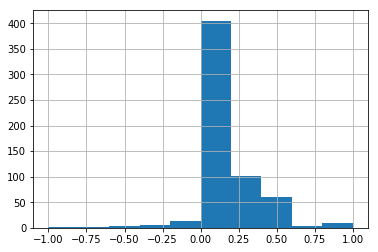

In [12]:
tweets['sentiment_score'].hist(bins=10)

In [74]:
def score2color(score):
    """Returns an RGB value based on the sentiment score"""        

    if score == 0:
        return [1, 1, 1]

    if score > 0:
        return [1-score, 1-score, score]
    else:
        score = abs(score)
        return [score, 1-score, 1-score]

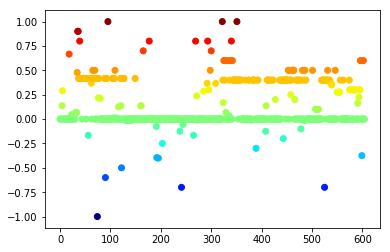

In [128]:
plt.scatter(x=np.arange(len(tweets)), y=tweets['sentiment_score'], c=tweets.sentiment_score, cmap='jet')

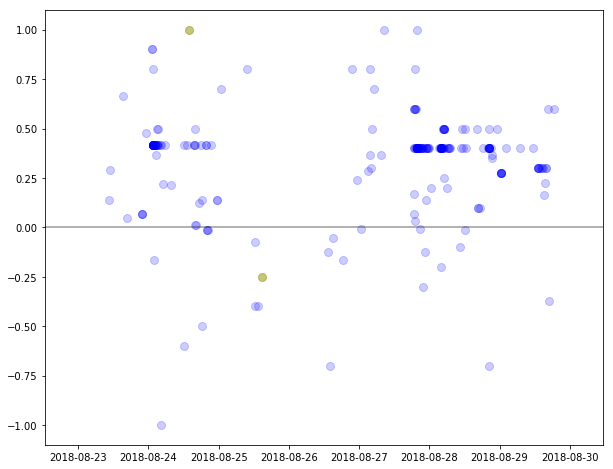

In [136]:
pos, neg = 95, 203

fig, ax = plt.subplots(figsize=(10,8))

mask = tweets['sentiment'] != 'neutral'
x = tweets.loc[mask]['created_at']
y = tweets.loc[mask]['sentiment_score']

xlim = [736928.5238512151, 736936.4705122107]
ms = 8

# for i in range(len(x)):
#     ax.plot(x.iloc[i], y.iloc[i], 'o', alpha=0.8, ms=ms, c=score2color(y.iloc[i]))
ax.plot(x, y, 'bo', alpha=0.2, markersize=ms, lw=2)#, markerfacecolor='none')
# ax.scatter(x, y)
ax.plot(xlim, [0, 0], 'k-', linewidth=2, alpha=0.3)
ax.plot(x[pos], y[pos], 'yo', markersize=ms, alpha=0.5)
ax.plot(x[neg], y[neg], 'yo', markersize=ms, alpha=0.5)
ax.set_xlim(xlim)
plt.show()

# plt.savefig('raw_sentiment.eps', type='eps', dpi=300)

In [137]:

ax.get_ylim()

(-1.1, 1.1)

### Average sentiment per day of the week

In [14]:
no_neutral = tweets[tweets.sentiment != 'neutral']
days = []
for i in range(len(no_neutral)):
    days.append(no_neutral.iloc[i]['created_at'].day)
no_neutral['day'] = days

/Users/john/Projects/TwitterTracker/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
score_by_day = no_neutral.groupby('day').mean()

In [16]:
score_by_day

,contributors,favorite_count,favorited,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,possibly_sensitive,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,truncated,sentiment_score
day,,,,,,,,,,,,,,,,,,,
23,NaN,0,0.0,1032684898883152896,1032684898883152896,1.032583e+18,1.032583e+18,4.056598e+07,4.056598e+07,0.000000,0.000000,0,NaN,NaN,0,0,0.0,0.250000,0.227395
24,NaN,0,0.0,1032899983233002752,1032899983233002752,1.031727e+18,1.031727e+18,8.032916e+08,8.032916e+08,0.016667,0.000000,0,1.032801e+18,1.032801e+18,0,0,0.0,0.150000,0.325992
25,NaN,0,0.0,1033301754428573056,1033301754428573056,1.033131e+18,1.033131e+18,6.202612e+08,6.202612e+08,0.000000,0.000000,0,NaN,NaN,0,0,0.0,0.166667,0.063194
26,NaN,0,0.0,1033769441261522944,1033769441261522944,1.033603e+18,1.033603e+18,6.065231e+08,6.065231e+08,0.000000,0.000000,0,NaN,NaN,0,0,0.0,0.166667,-0.001620
27,NaN,0,0.0,1034138856855896064,1034138856855896064,1.034065e+18,1.034065e+18,4.040498e+17,4.040498e+17,0.000000,0.044444,0,NaN,NaN,0,0,0.0,0.120690,0.397929
28,NaN,0,0.0,1034389097873158656,1034389097873158656,1.034203e+18,1.034203e+18,1.219586e+09,1.219586e+09,0.050847,0.022222,0,1.034375e+18,1.034375e+18,0,0,0.0,0.084746,0.350026
29,NaN,0,0.0,1034747385584074880,1034747385584074880,1.034770e+18,1.034770e+18,5.969991e+07,5.969991e+07,0.000000,0.000000,0,NaN,NaN,0,0,0.0,0.083333,0.294568


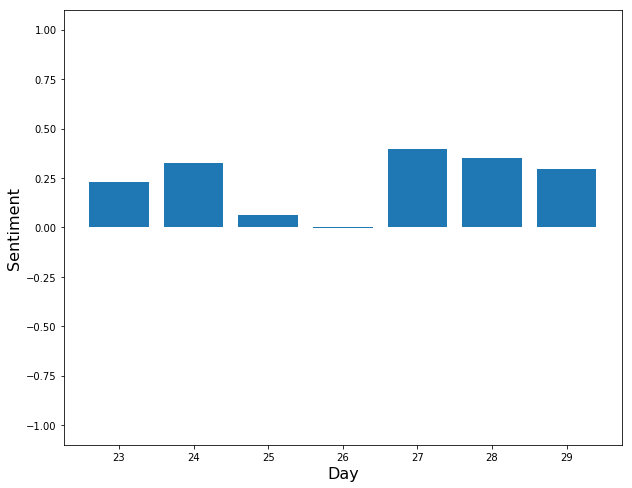

In [138]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(score_by_day.index, score_by_day['sentiment_score'])
ax.set_xlabel("Day", fontsize=FS)
ax.set_ylabel("Sentiment", fontsize=FS)
# plt.show()
ax.set_ylim([-1.1, 1.1])

plt.savefig('average_sentiment.eps', type='eps', dpi=300)